## package & plot style

In [14]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from darts.models import RandomForestModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse, mae, r2_score
import shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')


COLORS = {
    'IHSG': '#2E7D32',           # Green (primary)
    'IHSG_light': '#4CAF50',
    'IHSG_dark': '#1B5E20',    
    'STI': '#1976D2',            # Blue for regional index
    'Gold': '#FFD700',           # Gold color
    'Coal': '#FF5722',           # Orange-red
    'Copper': '#795548',         # Brown
    'Silver': '#9E9E9E',         # Gray
    'Tin': '#607D8B',            # Blue-gray
    'Nickel': '#FF9800',         # Orange
    'train': '#2E7D32',
    'actual': '#1976D2',
    'predicted': '#D32F2F',
    'error': '#9E9E9E',
    'split_line': '#616161',
}

COLOR_PALETTE = ['#2E7D32', '#D32F2F', '#F57C00', '#1976D2', '#7B1FA2', '#C2185B', '#FFD700']

# =========================================================================
# MATPLOTLIB THESIS STYLE
# =========================================================================
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100          # Display DPI
plt.rcParams['savefig.dpi'] = 300         # Export DPI (publication quality)
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.1

# Font settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Georgia']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Line settings
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 0.8

# Grid settings
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linewidth'] = 0.5

# Legend settings
plt.rcParams['legend.framealpha'] = 0.9
plt.rcParams['legend.edgecolor'] = '0.8'

print("Libraries imported successfully!")
print("Thesis color palette and matplotlib style configured.")

Libraries imported successfully!
Thesis color palette and matplotlib style configured.


## Load and Merge Data

In [15]:
# Load all datasets
print("="*60)
print("LOADING DATASETS")
print("="*60)

# IHSG (target) - Indonesian format dd/mm/yyyy
ihsg = pd.read_csv('dataset/ihsg_daily.csv')
ihsg['Date'] = pd.to_datetime(ihsg['Date'], format='%d/%m/%Y')
ihsg.columns = ['Date', 'IHSG']
print(f"IHSG: {len(ihsg)} rows, {ihsg['Date'].min()} to {ihsg['Date'].max()}")

# STI - Indonesian format dd/mm/yyyy
sti = pd.read_csv('dataset/STI.csv')
sti['Date'] = pd.to_datetime(sti['Date'], format='%d/%m/%Y')
sti.columns = ['Date', 'STI']
print(f"STI: {len(sti)} rows, {sti['Date'].min()} to {sti['Date'].max()}")

# Gold - Indonesian format dd/mm/yyyy
gold = pd.read_csv('dataset/Gold.csv')
gold['Date'] = pd.to_datetime(gold['Date'], format='%d/%m/%Y')
gold.columns = ['Date', 'Gold']
print(f"Gold: {len(gold)} rows, {gold['Date'].min()} to {gold['Date'].max()}")

# Commodities - US format mm/dd/yyyy
coal = pd.read_csv('dataset/Coal.csv')
coal['Date'] = pd.to_datetime(coal['Date'], format='%m/%d/%Y')
coal.columns = ['Date', 'Coal']
print(f"Coal: {len(coal)} rows, {coal['Date'].min()} to {coal['Date'].max()}")

copper = pd.read_csv('dataset/Copper.csv')
copper['Date'] = pd.to_datetime(copper['Date'], format='%m/%d/%Y')
copper.columns = ['Date', 'Copper']
print(f"Copper: {len(copper)} rows, {copper['Date'].min()} to {copper['Date'].max()}")

silver = pd.read_csv('dataset/Silver.csv')
silver['Date'] = pd.to_datetime(silver['Date'], format='%m/%d/%Y')
silver.columns = ['Date', 'Silver']
print(f"Silver: {len(silver)} rows, {silver['Date'].min()} to {silver['Date'].max()}")

tin = pd.read_csv('dataset/Tin.csv')
tin['Date'] = pd.to_datetime(tin['Date'], format='%m/%d/%Y')
tin.columns = ['Date', 'Tin']
print(f"Tin: {len(tin)} rows, {tin['Date'].min()} to {tin['Date'].max()}")

nickel = pd.read_csv('dataset/Nickel.csv')
nickel['Date'] = pd.to_datetime(nickel['Date'], format='%m/%d/%Y')
nickel.columns = ['Date', 'Nickel']
print(f"Nickel: {len(nickel)} rows, {nickel['Date'].min()} to {nickel['Date'].max()}")

LOADING DATASETS
IHSG: 2660 rows, 2015-01-02 00:00:00 to 2025-12-30 00:00:00
STI: 2766 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00
Gold: 2857 rows, 2015-01-01 00:00:00 to 2025-12-31 00:00:00
Coal: 2839 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00
Copper: 2780 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00
Silver: 2857 rows, 2015-01-01 00:00:00 to 2025-12-31 00:00:00
Tin: 2780 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00
Nickel: 2774 rows, 2015-01-02 00:00:00 to 2025-12-31 00:00:00


In [16]:
# Merge all datasets on Date (inner join to get common dates)
print("\n" + "="*60)
print("MERGING DATASETS")
print("="*60)

# Start with IHSG as base
df = ihsg.copy()

# Merge each dataset (Gold added)
for dataset, name in [(sti, 'STI'), (gold, 'Gold'), (coal, 'Coal'), (copper, 'Copper'), 
                       (silver, 'Silver'), (tin, 'Tin'), (nickel, 'Nickel')]:
    df = df.merge(dataset, on='Date', how='inner')
    print(f"After merging {name}: {len(df)} rows")

# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

print(f"\n✅ Final merged dataset: {len(df)} rows")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Columns: {df.columns.tolist()}")


MERGING DATASETS
After merging STI: 2620 rows
After merging Gold: 2620 rows
After merging Coal: 2620 rows
After merging Copper: 2570 rows
After merging Silver: 2570 rows
After merging Tin: 2570 rows
After merging Nickel: 2564 rows

✅ Final merged dataset: 2564 rows
Date range: 2015-01-02 00:00:00 to 2025-12-30 00:00:00
Columns: ['Date', 'IHSG', 'STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']


In [17]:
# Display merged data
print("="*60)
print("MERGED DATA PREVIEW")
print("="*60)
df.head(10)

MERGED DATA PREVIEW


,Date,IHSG,STI,Gold,Coal,Copper,Silver,Tin,Nickel
0,2015-01-02,5242.769,3370.59,1188.39,61.30,6255.0,15.7465,19645,14830
1,2015-01-05,5219.995,3328.28,1204.86,61.25,6145.0,16.1885,19495,15200
2,2015-01-06,5169.060,3281.95,1218.58,61.45,6145.0,16.5365,19775,15260
3,2015-01-07,5207.118,3298.36,1211.41,60.60,6115.0,16.5354,19700,15550
4,2015-01-08,5211.828,3345.11,1208.79,60.60,6104.0,16.3651,19780,15550
5,2015-01-09,5216.665,3338.44,1223.25,60.40,6090.0,16.5050,19550,15300
6,2015-01-12,5187.933,3344.89,1233.31,60.05,6017.0,16.5825,19900,15100
7,2015-01-13,5214.359,3341.07,1230.64,60.30,5860.0,17.0524,19525,14650
8,2015-01-14,5159.668,3326.16,1228.72,60.05,5548.0,16.8571,19375,14310
9,2015-01-15,5188.712,3338.84,1262.75,60.30,5630.0,16.9468,19355,14475


In [18]:
# Check data types and missing values
print("="*60)
print("DATA TYPES & MISSING VALUES")
print("="*60)
df.info()
print("\n" + "="*60)
print("MISSING VALUES PER COLUMN")
print("="*60)
print(df.isnull().sum())

DATA TYPES & MISSING VALUES
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2564 entries, 0 to 2563
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2564 non-null   datetime64[ns]
 1   IHSG    2564 non-null   float64       
 2   STI     2564 non-null   float64       
 3   Gold    2564 non-null   float64       
 4   Coal    2564 non-null   float64       
 5   Copper  2564 non-null   float64       
 6   Silver  2564 non-null   float64       
 7   Tin     2564 non-null   int64         
 8   Nickel  2564 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 180.4 KB

MISSING VALUES PER COLUMN
Date      0
IHSG      0
STI       0
Gold      0
Coal      0
Copper    0
Silver    0
Tin       0
Nickel    0
dtype: int64


## Exploratory Data Analysis (EDA)

In [20]:
# Descriptive statistics
print("="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)
df.describe().round(2)

DESCRIPTIVE STATISTICS


,Date,IHSG,STI,Gold,Coal,Copper,Silver,Tin,Nickel
count,2564,2564.00,2564.00,2564.00,2564.00,2564.00,2564.00,2564.00,2564.00
mean,2020-06-24 15:01:57.940717568,6185.65,3233.99,1768.07,123.94,7363.58,21.89,23718.21,15524.34
min,2015-01-02 00:00:00,3937.63,2233.48,1051.10,48.50,4331.00,11.98,13250.00,7595.00
25%,2017-09-28 18:00:00,5434.55,3065.02,1270.66,67.75,5850.75,16.48,18184.50,11863.00
50%,2020-06-20 12:00:00,6203.81,3212.52,1696.95,99.38,6903.00,19.03,20865.00,14977.50
75%,2023-03-14 06:00:00,6880.91,3356.28,1932.08,135.01,9077.38,24.79,29057.75,17898.50
max,2025-12-30 00:00:00,8710.70,4655.38,4484.47,457.80,12558.50,76.29,47540.00,48078.00
std,NaN,924.65,384.70,666.67,87.57,1817.12,7.97,7345.38,5061.51


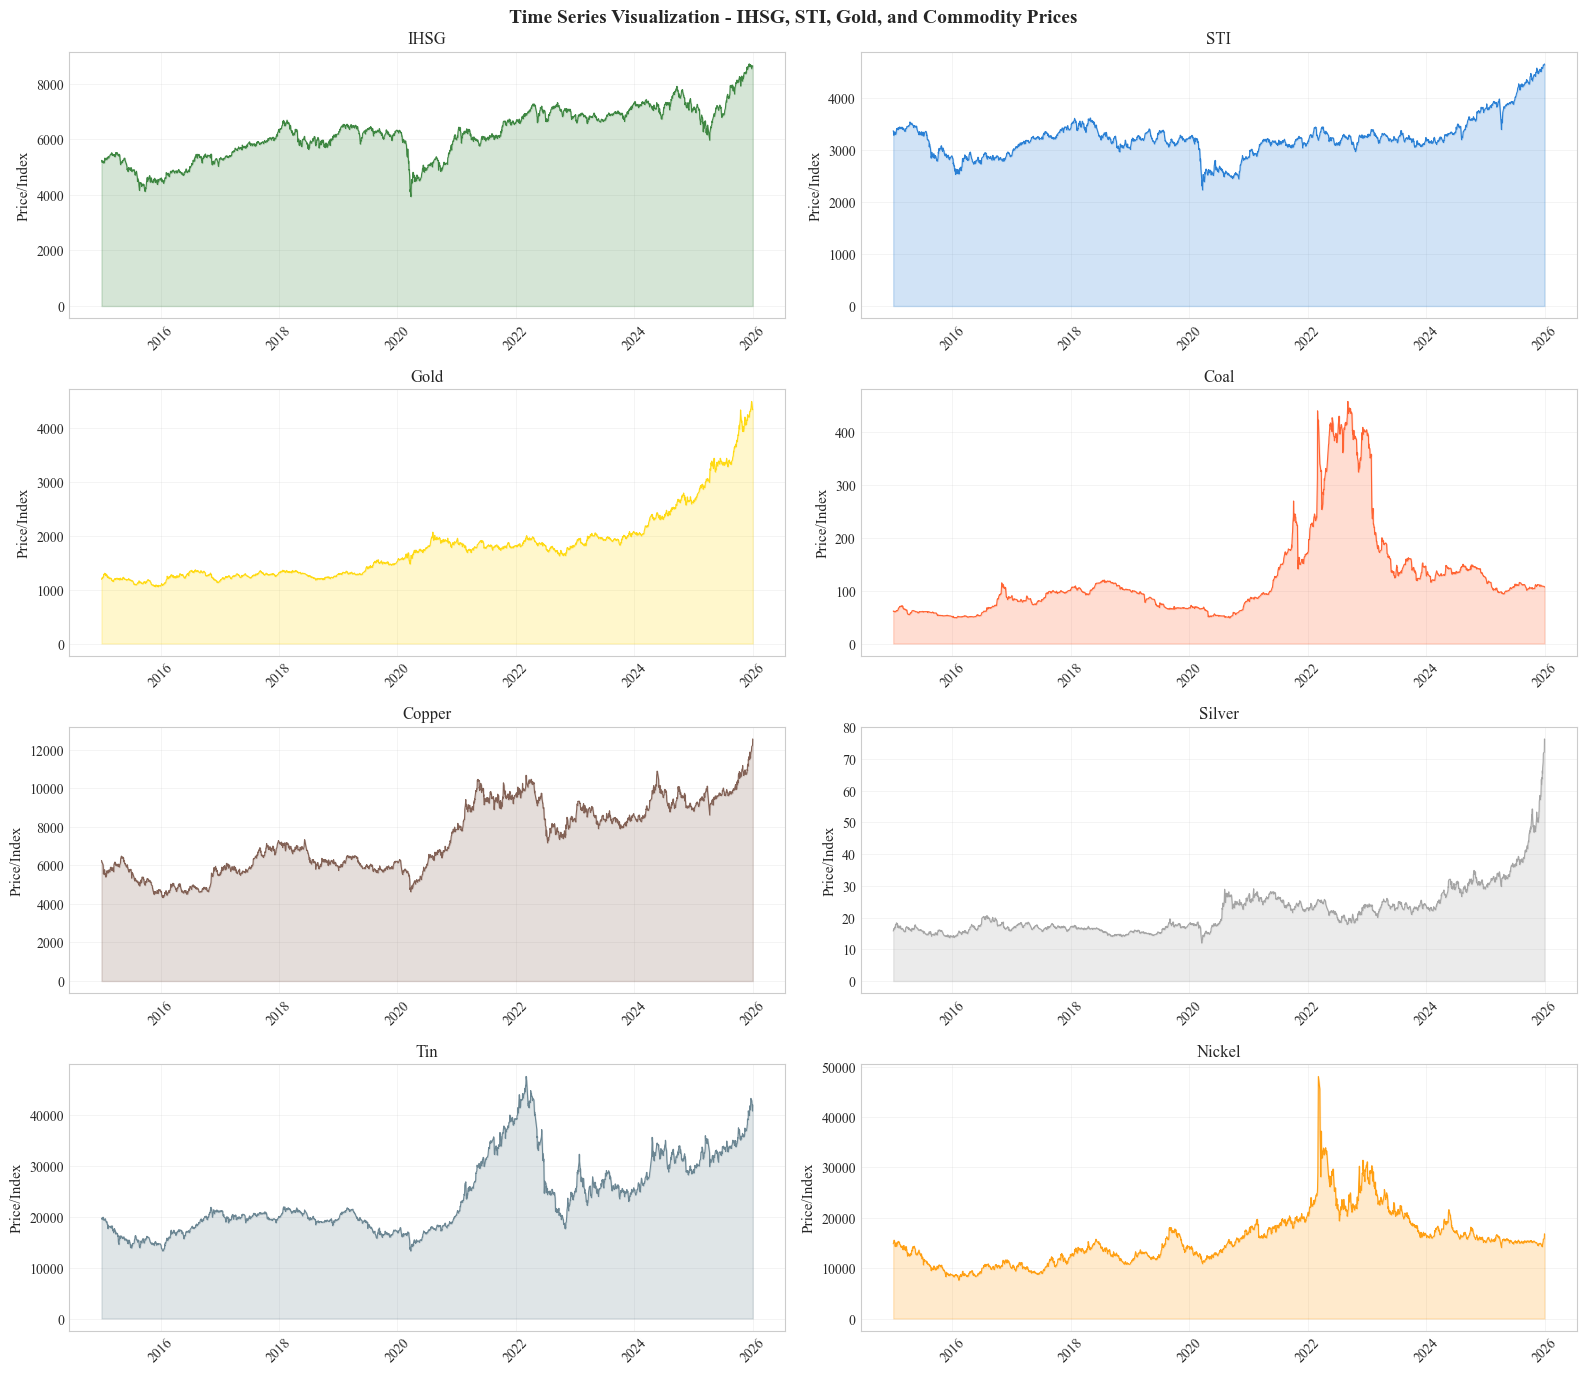

Figure saved: model2-figure/model2_eda_timeseries.png (300 DPI)


In [ ]:
# Visualization: Time series plots with thesis colors
fig, axes = plt.subplots(4, 2, figsize=(16, 14))
fig.suptitle('Time Series Visualization - IHSG, STI, Gold, and Commodity Prices', fontsize=14, fontweight='bold')

# Define colors from thesis palette (Gold added)
plot_config = [
    ('IHSG', COLORS['IHSG']),
    ('STI', COLORS['STI']),
    ('Gold', COLORS.get('Gold', '#FFD700')),  # Gold color
    ('Coal', COLORS['Coal']),
    ('Copper', COLORS['Copper']),
    ('Silver', COLORS['Silver']),
    ('Tin', COLORS['Tin']),
    ('Nickel', COLORS['Nickel']),
    ('Gold', '#FFD700')
]

for idx, (commodity, color) in enumerate(commodities):
    ax = axes[idx // 3, idx % 3]
    
    # Plot IHSG as background reference
    ax.plot(df_normalized['Date'], df_normalized['IHSG'], 
            color=COLORS['IHSG'], linewidth=1.2, label='IHSG', alpha=0.7)
    
    # Plot commodity with emphasis
    ax.plot(df_normalized['Date'], df_normalized[commodity], 
            color=color, linewidth=2, label=commodity, alpha=0.9)
    
    ax.set_title(f'IHSG vs {commodity}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Normalized')
    ax.legend(loc='best', fontsize=9, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('model2-figure/model2_ihsg_vs_commodities.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 3: All Commodities Movement (Spaghetti Plot)
fig, ax = plt.subplots(figsize=(14, 7))

# Plot IHSG as thick reference line
ax.plot(df_normalized['Date'], df_normalized['IHSG'], 
        color=COLORS['IHSG'], linewidth=2.5, label='IHSG', alpha=1.0, zorder=10)

# Plot all commodities
for commodity, color in commodities:
    ax.plot(df_normalized['Date'], df_normalized[commodity], 
            color=color, linewidth=1.2, label=commodity, alpha=0.8)

ax.set_title('IHSG and All Commodity Prices (Normalized 0-100)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Value')
ax.legend(loc='upper left', ncol=4, framealpha=0.9, fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model2-figure/model2_all_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figures saved:")
print("  - model2-figure/model2_ihsg_vs_sti_gold.png (300 DPI)")
print("  - model2-figure/model2_ihsg_vs_commodities.png (300 DPI)")
print("  - model2-figure/model2_all_normalized.png (300 DPI)")

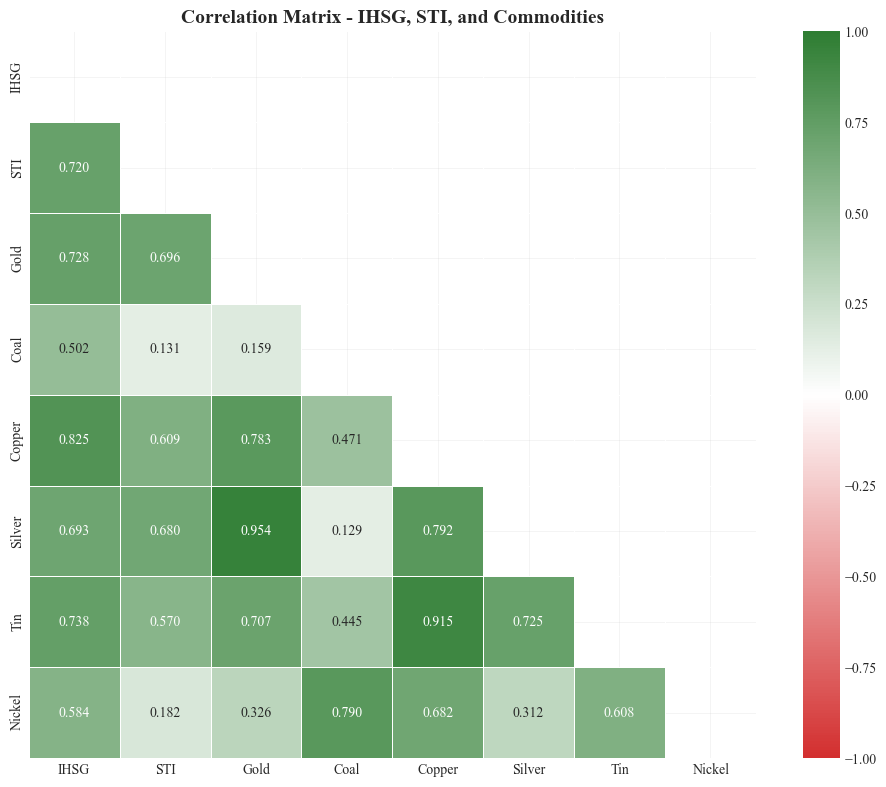

Figure saved: model2-figure/model2_correlation_matrix.png (300 DPI)

CORRELATION WITH IHSG
Copper          : +0.8253 (Strong Positive)
Tin             : +0.7376 (Strong Positive)
Gold            : +0.7279 (Strong Positive)
STI             : +0.7199 (Strong Positive)
Silver          : +0.6927 (Moderate Positive)
Nickel          : +0.5843 (Moderate Positive)
Coal            : +0.5023 (Moderate Positive)


In [22]:
# Correlation Analysis
fig, ax = plt.subplots(figsize=(10, 8))

corr_matrix = df.drop('Date', axis=1).corr()

# Custom colormap: Green (positive with IHSG) to Red (negative)
from matplotlib.colors import LinearSegmentedColormap
colors_cmap = ['#D32F2F', '#FFFFFF', '#2E7D32']  # Red - White - Green
custom_cmap = LinearSegmentedColormap.from_list('thesis_cmap', colors_cmap, N=256)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap=custom_cmap, 
            center=0, square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 10}, vmin=-1, vmax=1)

ax.set_title('Correlation Matrix - IHSG, STI, and Commodities', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model2-figure/model2_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2-figure/model2_correlation_matrix.png (300 DPI)")

print("\n" + "="*60)
print("CORRELATION WITH IHSG")
print("="*60)
ihsg_corr = corr_matrix['IHSG'].drop('IHSG').sort_values(ascending=False)
for var, corr in ihsg_corr.items():
    direction = "Positive" if corr > 0 else "Negative"
    strength = "Strong" if abs(corr) > 0.7 else "Moderate" if abs(corr) > 0.4 else "Weak"
    print(f"{var:15} : {corr:+.4f} ({strength} {direction})")

## Create Darts TimeSeries Objects

In [23]:
# target dan covariates
TARGET_COL = 'IHSG'
COVARIATE_COLS = ['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']

# =========================================================================
# SOLUTION FOR IRREGULAR TRADING DAYS (MULTI-MARKET DATA)
# =========================================================================
# Problem: Different markets have different holidays
#   - IHSG: Indonesian holidays
#   - STI: Singapore holidays  
#   - Commodities: International market holidays
# Solution: Use RangeIndex (integer) instead of DatetimeIndex
#   - Darts treats data as sequential without calendar frequency constraints
#   - Store date mapping separately for visualization

print("="*60)
print("TIMESERIES DATA PREPARATION")
print("="*60)

# Save date mapping for later visualization (format: dd/mm/yyyy to match dataset)
date_mapping = df[['Date']].copy()
date_mapping['idx'] = range(len(date_mapping))
date_mapping['Date'] = date_mapping['Date'].dt.strftime('%d/%m/%Y')
date_mapping.to_csv('trading_day_mapping.csv', index=False)
print("Date mapping saved to 'trading_day_mapping.csv' (format: dd/mm/yyyy)")

# Create DataFrame with RangeIndex (integer index)
df_ts = df.drop('Date', axis=1).reset_index(drop=True)

print(f"\nTotal actual trading days: {len(df_ts)}")
print(f"Date range: {df['Date'].min().strftime('%d/%m/%Y')} to {df['Date'].max().strftime('%d/%m/%Y')}")
print(f"Index type: RangeIndex (integer sequential)")
print(f"Missing values: {df_ts.isnull().sum().sum()}")

print("\n" + "="*60)
print("CREATING DARTS TIMESERIES (INTEGER INDEX)")
print("="*60)

# Create TimeSeries with integer index (no frequency constraint)
target_series = TimeSeries.from_dataframe(
    df_ts, 
    value_cols=TARGET_COL
)

covariates = TimeSeries.from_dataframe(
    df_ts,
    value_cols=COVARIATE_COLS
)

print(f"\nTarget Series (IHSG):")
print(f"  - Start index: {target_series.start_time()}")
print(f"  - End index: {target_series.end_time()}")
print(f"  - Length: {len(target_series)} trading days")
print(f"  - Frequency: {target_series.freq} (integer-based)")

print(f"\nCovariates ({len(COVARIATE_COLS)} variables):")
print(f"  - {', '.join(COVARIATE_COLS)}")
print(f"  - Length: {len(covariates)} trading days")

print("\n✅ TimeSeries created successfully!")
print("✅ Using RangeIndex to handle irregular trading days")
print("✅ No NaN from calendar gaps - only actual trading days")

TIMESERIES DATA PREPARATION
Date mapping saved to 'trading_day_mapping.csv' (format: dd/mm/yyyy)

Total actual trading days: 2564
Date range: 02/01/2015 to 30/12/2025
Index type: RangeIndex (integer sequential)
Missing values: 0

CREATING DARTS TIMESERIES (INTEGER INDEX)

Target Series (IHSG):
  - Start index: 0
  - End index: 2563
  - Length: 2564 trading days
  - Frequency: 1 (integer-based)

Covariates (7 variables):
  - STI, Gold, Coal, Copper, Silver, Tin, Nickel
  - Length: 2564 trading days

✅ TimeSeries created successfully!
✅ Using RangeIndex to handle irregular trading days
✅ No NaN from calendar gaps - only actual trading days


In [24]:
df_ts

,IHSG,STI,Gold,Coal,Copper,Silver,Tin,Nickel
0,5242.769,3370.59,1188.39,61.30,6255.0,15.7465,19645,14830
1,5219.995,3328.28,1204.86,61.25,6145.0,16.1885,19495,15200
2,5169.060,3281.95,1218.58,61.45,6145.0,16.5365,19775,15260
3,5207.118,3298.36,1211.41,60.60,6115.0,16.5354,19700,15550
4,5211.828,3345.11,1208.79,60.60,6104.0,16.3651,19780,15550
...,...,...,...,...,...,...,...,...
2559,8645.844,4610.29,4443.60,108.25,11925.0,69.0383,42947,15276
2560,8584.782,4638.97,4484.47,108.25,12060.5,71.4300,42792,15739
2561,8537.911,4636.34,4479.42,108.25,12162.5,71.8700,42815,15786
2562,8644.256,4633.64,4332.35,107.95,12222.0,72.1370,40743,15814


## Train/Test Split and Scaling

In [25]:
# Train/Test Split (80/20)
TRAIN_RATIO = 0.8
split_point = int(len(target_series) * TRAIN_RATIO)

train_target = target_series[:split_point]
test_target = target_series[split_point:]

train_cov = covariates[:split_point]
test_cov = covariates[split_point:]

# =========================================================================
# SCALING OPTIONS
# =========================================================================
from sklearn.preprocessing import MinMaxScaler, StandardScaler

SCALER_TYPE = 'minmax'  # Options: 'minmax' or 'standard'

if SCALER_TYPE == 'minmax':
    scaler_target = Scaler(scaler=MinMaxScaler())
    scaler_cov = Scaler(scaler=MinMaxScaler())
    print("Using: MinMaxScaler (scales to [0, 1])")
elif SCALER_TYPE == 'standard':
    scaler_target = Scaler(scaler=StandardScaler())
    scaler_cov = Scaler(scaler=StandardScaler())
    print("Using: StandardScaler (z-score normalization)")

# Fit on training data only to avoid data leakage
train_target_scaled = scaler_target.fit_transform(train_target)
test_target_scaled = scaler_target.transform(test_target)

train_cov_scaled = scaler_cov.fit_transform(train_cov)
test_cov_scaled = scaler_cov.transform(test_cov)

# Full scaled series for backtesting
target_scaled = scaler_target.transform(target_series)
cov_scaled = scaler_cov.transform(covariates)

print("="*60)
print("TRAIN/TEST SPLIT")
print("="*60)
print(f"Train Period: {train_target.start_time()} to {train_target.end_time()} ({len(train_target)} days)")
print(f"Test Period:  {test_target.start_time()} to {test_target.end_time()} ({len(test_target)} days)")
print(f"\nTrain/Test Ratio: {TRAIN_RATIO*100:.0f}% / {(1-TRAIN_RATIO)*100:.0f}%")

# Verify NO NaN values
print("\n" + "="*60)
print("DATA QUALITY CHECK (NaN)")
print("="*60)
print(f"Target (scaled) NaN: {np.isnan(target_scaled.values()).sum()}")
print(f"Past Covariates NaN: {np.isnan(cov_scaled.values()).sum()}")

if np.isnan(target_scaled.values()).sum() == 0:
    print("\n✅ All data is clean - NO NaN values!")
else:
    print("\n⚠️ WARNING: NaN values detected!")

# Show scaled data statistics
print("\n" + "="*60)
print(f"SCALED DATA STATISTICS ({SCALER_TYPE.upper()})")
print("="*60)
train_vals = train_target_scaled.values().flatten()
print(f"Target (Train) - Min: {train_vals.min():.4f}, Max: {train_vals.max():.4f}, Mean: {train_vals.mean():.4f}")

print("\n" + "="*60)
print("COVARIATE SUMMARY")
print("="*60)
print(f"Past Covariates: {covariates.components.tolist()}")

Using: MinMaxScaler (scales to [0, 1])
TRAIN/TEST SPLIT
Train Period: 0 to 2050 (2051 days)
Test Period:  2051 to 2563 (513 days)

Train/Test Ratio: 80% / 20%

DATA QUALITY CHECK (NaN)
Target (scaled) NaN: 0
Past Covariates NaN: 0

✅ All data is clean - NO NaN values!

SCALED DATA STATISTICS (MINMAX)
Target (Train) - Min: 0.0000, Max: 1.0000, Mean: 0.5795

COVARIATE SUMMARY
Past Covariates: ['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']


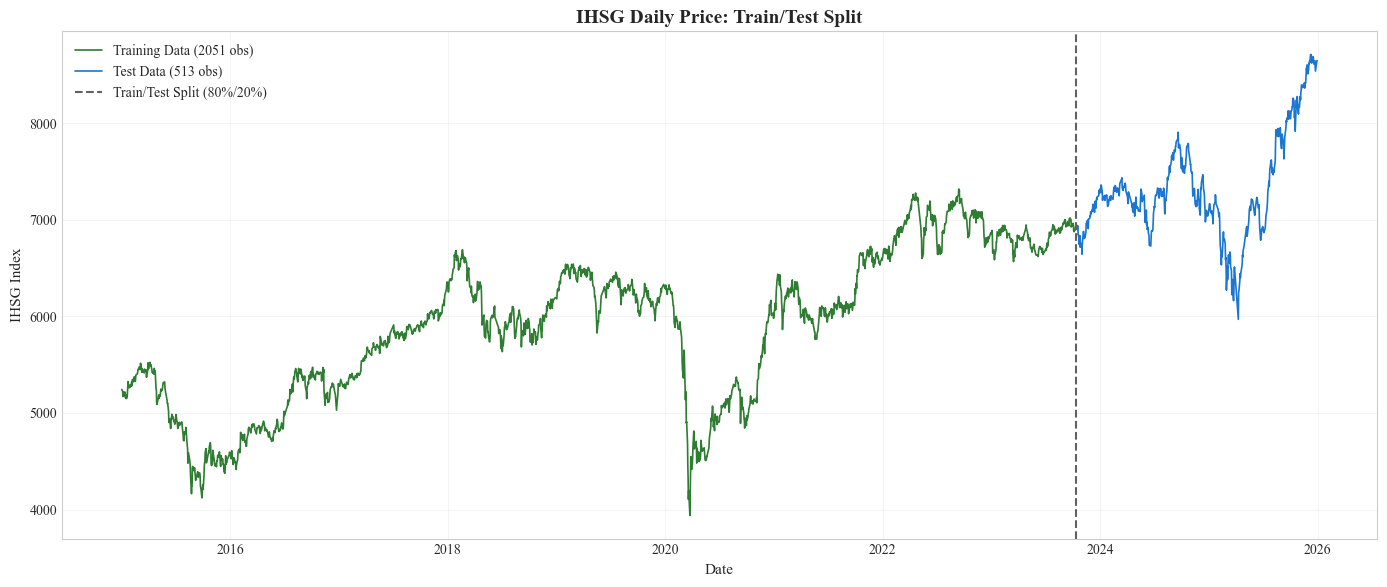


Train period: 02/01/2015 - 12/10/2023
Test period:  13/10/2023 - 30/12/2025


In [26]:
# =========================================================================
# VISUALIZATION: TRAIN/TEST SPLIT
# =========================================================================

# Load date mapping (format: dd/mm/yyyy)
date_map = pd.read_csv('trading_day_mapping.csv')
date_map['Date'] = pd.to_datetime(date_map['Date'], format='%d/%m/%Y')

# Get dates for train and test
train_dates = date_map.loc[train_target.time_index.values, 'Date'].values
test_dates = date_map.loc[test_target.time_index.values, 'Date'].values

fig, ax = plt.subplots(figsize=(14, 6))

# Plot train and test data
ax.plot(train_dates, train_target.values(), 
        label=f'Training Data ({len(train_target)} obs)', 
        color=COLORS['train'], linewidth=1.2)
ax.plot(test_dates, test_target.values(), 
        label=f'Test Data ({len(test_target)} obs)', 
        color=COLORS['actual'], linewidth=1.2)

# Add vertical line at split point
split_date = date_map.loc[split_point-1, 'Date']
ax.axvline(x=split_date, color=COLORS['split_line'], linestyle='--', 
           linewidth=1.5, label=f'Train/Test Split ({TRAIN_RATIO*100:.0f}%/{(1-TRAIN_RATIO)*100:.0f}%)')

# Styling
ax.set_title('IHSG Daily Price: Train/Test Split', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('IHSG Index')
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model2-figure/model2_train_test_split.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTrain period: {pd.to_datetime(train_dates[0]).strftime('%d/%m/%Y')} - {pd.to_datetime(train_dates[-1]).strftime('%d/%m/%Y')}")
print(f"Test period:  {pd.to_datetime(test_dates[0]).strftime('%d/%m/%Y')} - {pd.to_datetime(test_dates[-1]).strftime('%d/%m/%Y')}")

## 6. Hyperparameter Tuning with GridSearch

In [ ]:
# =========================================================================
# HYPERPARAMETER TUNING CONFIGURATION
# =========================================================================
TUNING_METHOD = 'gridsearch'  # Options: 'gridsearch', 'optuna'

# Forecast horizon: 1 day ahead
OUTPUT_CHUNK_LENGTH = 1

print("="*60)
print(f"HYPERPARAMETER TUNING METHOD: {TUNING_METHOD.upper()}")
print("="*60)
print(f"\nForecast Horizon: {OUTPUT_CHUNK_LENGTH} day(s) ahead")

if TUNING_METHOD == 'gridsearch':
    param_grid = {
        'lags': [5, 10, 21],
        'lags_past_covariates': [5, 10, 21],
        'n_estimators': [100, 200, 300],     
        'max_depth': [5, 10, None],          
    }
    
    print("\nGridSearch Parameters:")
    for param, values in param_grid.items():
        print(f"  {param}: {values}")
    
    total_combinations = 1
    for values in param_grid.values():
        total_combinations *= len(values)
    print(f"\nTotal combinations to evaluate: {total_combinations}")

elif TUNING_METHOD == 'optuna':
    print("\nOptuna will use TPE (Tree-structured Parzen Estimator) sampler")
    print("\nSearch Space:")
    print("  [Darts Parameters]")
    print("  lags: [5, 10, 21, 42] (categorical) - ~1wk, 2wk, 1mo, 2mo trading days")
    print("  lags_past_covariates: [5, 10, 21, 42] (categorical)")
    print("  n_estimators: [100, 200, 300] (categorical)")
    print("  max_depth: [5, 7, 10, None] (categorical)")
    print("\n  [sklearn Parameters via **kwargs]")
    print("  max_features: ['sqrt', 'log2', None] (categorical)")
    print("  min_samples_split: [2, 5, 10] (categorical)")
    print("  min_samples_leaf: [1, 2, 4] (categorical)")
    print("  bootstrap: [True, False] (categorical)")
    
    print("\n" + "="*60)
    print("COVARIATE TYPES")
    print("="*60)
    print("Past Covariates (known until t):")
    for col in COVARIATE_COLS:
        print(f"  - {col}")

HYPERPARAMETER TUNING METHOD: OPTUNA

Forecast Horizon: 1 day(s) ahead

Optuna will use TPE (Tree-structured Parzen Estimator) sampler

Search Space:
  [Darts Parameters]
  lags: [5, 10, 21, 42] (categorical) - ~1wk, 2wk, 1mo, 2mo trading days
  lags_past_covariates: [5, 10, 21, 42] (categorical)
  n_estimators: [100, 200, 300] (categorical)
  max_depth: [5, 7, 10, None] (categorical)

  [sklearn Parameters via **kwargs]
  max_features: ['sqrt', 'log2', None] (categorical)
  min_samples_split: [2, 5, 10] (categorical)
  min_samples_leaf: [1, 2, 4] (categorical)
  bootstrap: [True, False] (categorical)

COVARIATE TYPES
Past Covariates (known until t):
  - STI
  - Gold
  - Coal
  - Copper
  - Silver
  - Tin
  - Nickel


In [58]:
# =========================================================================
# RUN HYPERPARAMETER TUNING
# =========================================================================
if TUNING_METHOD == 'gridsearch':
    print("="*60)
    print("RUNNING GRIDSEARCH (this may take several minutes...)")
    print("="*60)

    best_model, best_params, best_score = RandomForestModel.gridsearch(
        parameters=param_grid,
        series=train_target_scaled,
        past_covariates=cov_scaled,
        val_series=test_target_scaled,
        metric=mape,
        verbose=True,
        n_jobs=-1,
    )

    print("\n" + "="*60)
    print("GRIDSEARCH RESULTS")
    print("="*60)
    print(f"Best MAPE Score: {best_score:.4f}%")
    print(f"\nBest Hyperparameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

elif TUNING_METHOD == 'optuna':
    import optuna
    from optuna.samplers import TPESampler
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    def objective(trial):
        # Darts parameters
        lags = trial.suggest_categorical('lags', [5, 10, 21, 42])
        lags_past_covariates = trial.suggest_categorical('lags_past_covariates', [5, 10, 21, 42])
        n_estimators = trial.suggest_categorical('n_estimators', [100, 200, 300])
        max_depth = trial.suggest_categorical('max_depth', [5, 7, 10, None])
        
        # sklearn parameters via **kwargs
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5, 10])
        min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2, 4])
        bootstrap = trial.suggest_categorical('bootstrap', [True, False])
        
        try:
            model = RandomForestModel(
                lags=lags,
                lags_past_covariates=lags_past_covariates,
                output_chunk_length=OUTPUT_CHUNK_LENGTH,
                n_estimators=n_estimators,
                max_depth=max_depth,
                multi_models=True,
                random_state=42,
                max_features=max_features,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                bootstrap=bootstrap,
                n_jobs=-1
            )
            model.fit(
                train_target_scaled, 
                past_covariates=cov_scaled
            )
            
            # Use historical_forecasts for 1-step-ahead evaluation
            backtest_pred = model.historical_forecasts(
                series=target_scaled,
                past_covariates=cov_scaled,
                start=test_target_scaled.start_time(),
                forecast_horizon=1,
                retrain=False,
                verbose=False
            )
            
            mape_score = mape(test_target_scaled, backtest_pred)
            return mape_score
            
        except Exception as e:
            # Print error for debugging (remove in production)
            print(f"Trial failed: {str(e)[:100]}")
            return float('inf')
    
    def print_callback(study, trial):
        if trial.number % 10 == 0:
            print(f"  Trial {trial.number}: MAPE = {trial.value:.4f}% | Best so far: {study.best_value:.4f}%")
    
    print("="*60)
    print("RUNNING OPTUNA OPTIMIZATION")
    print("="*60)
    
    N_TRIALS = 100
    total_combinations = 4 * 4 * 3 * 4 * 3 * 3 * 3 * 2
    print(f"\nTotal possible combinations: {total_combinations}")
    print(f"Number of trials: {N_TRIALS} ({N_TRIALS/total_combinations*100:.1f}% of search space)")
    print(f"Forecast horizon: {OUTPUT_CHUNK_LENGTH} day (1-step-ahead)")
    print(f"\nCovariates:")
    print(f"  - Past: {covariates.components.tolist()}")
    print("\nProgress (every 10 trials):")
    
    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=42)
    )
    
    study.optimize(
        objective, 
        n_trials=N_TRIALS, 
        callbacks=[print_callback],
        show_progress_bar=True
    )
    
    best_params = study.best_trial.params.copy()
    best_params['output_chunk_length'] = OUTPUT_CHUNK_LENGTH
    best_score = study.best_value
    
    print("\n" + "="*60)
    print("OPTUNA RESULTS")
    print("="*60)
    print(f"Best MAPE Score: {best_score:.4f}%")
    print(f"Total Trials: {len(study.trials)}")
    print(f"\nBest Hyperparameters:")
    print("\n  [Darts Parameters]")
    for param in ['lags', 'lags_past_covariates', 'n_estimators', 'max_depth', 'output_chunk_length']:
        if param in best_params:
            print(f"    {param}: {best_params[param]}")
    print("\n  [sklearn Parameters (via **kwargs)]")
    for param in ['max_features', 'min_samples_split', 'min_samples_leaf', 'bootstrap']:
        if param in best_params:
            print(f"    {param}: {best_params[param]}")
    
    print("\n" + "="*60)
    print("TOP 5 TRIALS")
    print("="*60)
    trials_df = study.trials_dataframe()
    trials_df = trials_df.sort_values('value').head(5)
    for idx, row in trials_df.iterrows():
        print(f"  Trial {row['number']}: MAPE = {row['value']:.4f}%")

RUNNING OPTUNA OPTIMIZATION

Total possible combinations: 10368
Number of trials: 100 (1.0% of search space)
Forecast horizon: 1 day (1-step-ahead)

Covariates:
  - Past: ['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']

Progress (every 10 trials):


  0%|          | 0/100 [00:00<?, ?it/s]

  Trial 0: MAPE = 7.8341% | Best so far: 7.8341%
  Trial 10: MAPE = 9.3816% | Best so far: 7.1728%
  Trial 20: MAPE = 9.3953% | Best so far: 7.1728%
  Trial 30: MAPE = 7.1463% | Best so far: 7.1463%
  Trial 40: MAPE = 11.2644% | Best so far: 7.1463%
  Trial 50: MAPE = 7.9694% | Best so far: 7.1463%
  Trial 60: MAPE = 10.9370% | Best so far: 7.1420%
  Trial 70: MAPE = 26.1633% | Best so far: 7.1420%
  Trial 80: MAPE = 19.7674% | Best so far: 7.1420%
  Trial 90: MAPE = 9.3956% | Best so far: 7.1420%

OPTUNA RESULTS
Best MAPE Score: 7.1420%
Total Trials: 100

Best Hyperparameters:

  [Darts Parameters]
    lags: 5
    lags_past_covariates: 21
    n_estimators: 300
    max_depth: None
    output_chunk_length: 1

  [sklearn Parameters (via **kwargs)]
    max_features: None
    min_samples_split: 5
    min_samples_leaf: 4
    bootstrap: False

TOP 5 TRIALS
  Trial 54: MAPE = 7.1420%
  Trial 92: MAPE = 7.1443%
  Trial 94: MAPE = 7.1443%
  Trial 81: MAPE = 7.1443%
  Trial 87: MAPE = 7.1443%


## 7. Train Best Model and Generate Predictions

In [59]:
# =========================================================================
# TRAIN FINAL MODEL WITH BEST PARAMETERS
# =========================================================================
print("\n" + "="*60)
print("TRAINING FINAL MODEL WITH BEST PARAMETERS")
print("="*60)

if TUNING_METHOD == 'optuna':
    final_model = RandomForestModel(
        lags=best_params['lags'],
        lags_past_covariates=best_params['lags_past_covariates'],
        output_chunk_length=OUTPUT_CHUNK_LENGTH,
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        multi_models=True,
        random_state=42,
        max_features=best_params.get('max_features'),
        min_samples_split=best_params.get('min_samples_split', 2),
        min_samples_leaf=best_params.get('min_samples_leaf', 1),
        bootstrap=best_params.get('bootstrap', True),
        n_jobs=-1
    )
    final_model.fit(
        train_target_scaled, 
        past_covariates=cov_scaled
    )
else:
    final_model = best_model
    
print("Final model trained successfully!")
print(f"\nModel Configuration:")
print(f"  - Tuning Method: {TUNING_METHOD.upper()}")
print(f"  - Best MAPE: {best_score:.4f}%")
print(f"  - Forecast Horizon: {OUTPUT_CHUNK_LENGTH} day (1-step-ahead)")
print(f"\nCovariates Used:")
print(f"  - Past: {covariates.components.tolist()}")


TRAINING FINAL MODEL WITH BEST PARAMETERS
Final model trained successfully!

Model Configuration:
  - Tuning Method: OPTUNA
  - Best MAPE: 7.1420%
  - Forecast Horizon: 1 day (1-step-ahead)

Covariates Used:
  - Past: ['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']


## 8. Generate Predictions (1-Step-Ahead)

In [60]:
# =========================================================================
# GENERATE 1-STEP-AHEAD PREDICTIONS
# =========================================================================
# Using historical_forecasts for rolling 1-step-ahead prediction
# This simulates real-world scenario: predict day t+1, then move forward

predictions_scaled = final_model.historical_forecasts(
    series=target_scaled,
    past_covariates=cov_scaled,
    start=test_target_scaled.start_time(),
    forecast_horizon=1,  # 1 day ahead
    retrain=False,       # Use the trained model without retraining
    verbose=True
)

# Inverse transform to original scale
predictions = scaler_target.inverse_transform(predictions_scaled)
test_actual = scaler_target.inverse_transform(test_target_scaled)

print("="*60)
print("PREDICTIONS GENERATED (1-Step-Ahead)")
print("="*60)
print(f"Prediction Period: {predictions.start_time()} to {predictions.end_time()}")
print(f"Number of predictions: {len(predictions)} trading days")
print(f"Forecast Method: Rolling 1-day-ahead forecast")
print(f"\nCovariates Used:")
print(f"  - Past: {covariates.components.tolist()}")

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

PREDICTIONS GENERATED (1-Step-Ahead)
Prediction Period: 2051 to 2563
Number of predictions: 513 trading days
Forecast Method: Rolling 1-day-ahead forecast

Covariates Used:
  - Past: ['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']


## 9. Model Evaluation

In [61]:
# =========================================================================
# MODEL EVALUATION METRICS
# =========================================================================
mape_score = mape(test_actual, predictions)
rmse_score = rmse(test_actual, predictions)
mae_score = mae(test_actual, predictions)
r2 = r2_score(test_actual, predictions)

print("="*60)
print("MODEL EVALUATION METRICS")
print("="*60)
print(f"MAPE (Mean Absolute Percentage Error): {mape_score:.4f}%")
print(f"RMSE (Root Mean Square Error):         {rmse_score:.4f}")
print(f"MAE (Mean Absolute Error):             {mae_score:.4f}")
print(f"R² Score:                              {r2:.4f}")
print("="*60)

# Interpretation
print("\nINTERPRETATION:")
if mape_score < 5:
    print(f"  MAPE < 5%: Excellent forecasting accuracy")
elif mape_score < 10:
    print(f"  MAPE < 10%: Good forecasting accuracy")
elif mape_score < 20:
    print(f"  MAPE < 20%: Reasonable forecasting accuracy")
else:
    print(f"  MAPE > 20%: Poor forecasting accuracy")

MODEL EVALUATION METRICS
MAPE (Mean Absolute Percentage Error): 3.5381%
RMSE (Root Mean Square Error):         462.7110
MAE (Mean Absolute Error):             279.8590
R² Score:                              0.2512

INTERPRETATION:
  MAPE < 5%: Excellent forecasting accuracy


Aligned data points: test_actual=513, predictions=513


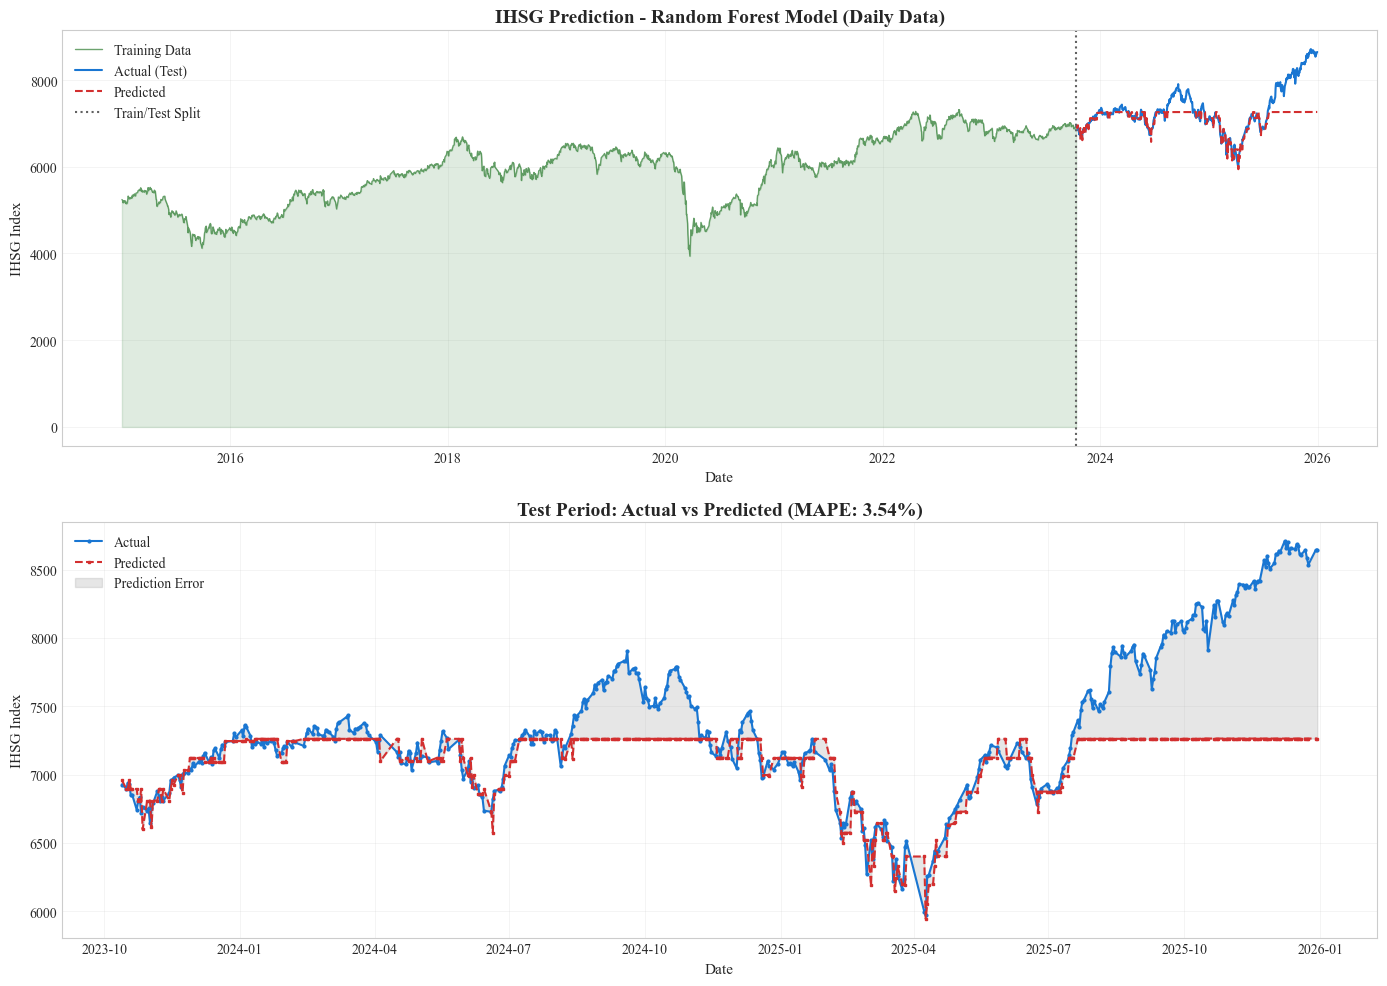

Figure saved: model2-figure/model2_prediction_results.png (300 DPI)


In [ ]:
# =========================================================================
# VISUALIZATION: ACTUAL VS PREDICTED
# =========================================================================

# Load date mapping (format: dd/mm/yyyy)
date_map = pd.read_csv('trading_day_mapping.csv')
date_map['Date'] = pd.to_datetime(date_map['Date'], format='%d/%m/%Y')

# Align test_actual with predictions time index (predictions may start later due to lags)
test_actual_aligned = test_actual.slice_intersect(predictions)
pred_aligned = predictions.slice_intersect(test_actual)

print(f"Aligned data points: test_actual={len(test_actual_aligned)}, predictions={len(pred_aligned)}")

# Convert integer indices to actual dates for plotting
train_dates = date_map.loc[train_target.time_index.values, 'Date'].values
test_dates = date_map.loc[test_actual.time_index.values, 'Date'].values
pred_dates = date_map.loc[predictions.time_index.values, 'Date'].values
test_aligned_dates = date_map.loc[test_actual_aligned.time_index.values, 'Date'].values
pred_aligned_dates = date_map.loc[pred_aligned.time_index.values, 'Date'].values

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Full time series with predictions
ax1 = axes[0]
ax1.plot(train_dates, train_target.values(), 
         label='Training Data', color=COLORS['train'], linewidth=1, alpha=0.7)
ax1.plot(test_dates, test_actual.values(), 
         label='Actual (Test)', color=COLORS['actual'], linewidth=1.5)
ax1.plot(pred_dates, predictions.values(), 
         label='Predicted', color=COLORS['predicted'], linewidth=1.5, linestyle='--')
ax1.axvline(x=date_map.loc[split_point-1, 'Date'], color=COLORS['split_line'], linestyle=':', linewidth=1.5, label='Train/Test Split')
ax1.fill_between(train_dates, train_target.values().flatten(), alpha=0.15, color=COLORS['train'])
ax1.set_title('IHSG Prediction - Random Forest Model (Daily Data)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('IHSG Index')
ax1.legend(loc='upper left', framealpha=0.9)
ax1.grid(True, alpha=0.3)

# Plot 2: Test period close-up (using aligned data)
ax2 = axes[1]
ax2.plot(test_aligned_dates, test_actual_aligned.values(), 
         label='Actual', color=COLORS['actual'], linewidth=1.5, marker='o', markersize=2)
ax2.plot(pred_aligned_dates, pred_aligned.values(), 
         label='Predicted', color=COLORS['predicted'], linewidth=1.5, linestyle='--', marker='s', markersize=2)
ax2.fill_between(test_aligned_dates, 
                  test_actual_aligned.values().flatten(), 
                  pred_aligned.values().flatten(), 
                  alpha=0.25, color=COLORS['error'], label='Prediction Error')
ax2.set_title(f'Test Period: Actual vs Predicted (MAPE: {mape_score:.2f}%)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('IHSG Index')
ax2.legend(loc='upper left', framealpha=0.9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model2-figure/model2_prediction_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2-figure/model2_prediction_results.png (300 DPI)")

## 10. Feature Importance with SHAP

In [63]:
# Prepare feature matrix for SHAP
lags = best_params['lags']
lags_cov = best_params['lags_past_covariates']

# Create lagged feature dataframe
def create_lagged_features(target_df, cov_df, target_lags, cov_lags):
    """Create lagged features for SHAP analysis"""
    max_lag = max(target_lags, cov_lags)
    features = pd.DataFrame(index=target_df.index[max_lag:])
    
    # Target lags
    for lag in range(1, target_lags + 1):
        features[f'IHSG_lag{lag}'] = target_df['IHSG'].shift(lag).values[max_lag:]
    
    # Covariate lags
    for col in cov_df.columns:
        for lag in range(1, cov_lags + 1):
            features[f'{col}_lag{lag}'] = cov_df[col].shift(lag).values[max_lag:]
    
    return features.dropna()

# Prepare data
target_df = df.set_index('Date')[['IHSG']]
cov_df = df.set_index('Date')[COVARIATE_COLS]

X_features = create_lagged_features(target_df, cov_df, lags, lags_cov)

print("="*60)
print("FEATURE MATRIX FOR SHAP")
print("="*60)
print(f"Feature matrix shape: {X_features.shape}")
print(f"\nFeatures ({len(X_features.columns)}):")
for i, col in enumerate(X_features.columns, 1):
    print(f"  {i}. {col}")

FEATURE MATRIX FOR SHAP
Feature matrix shape: (2543, 152)

Features (152):
  1. IHSG_lag1
  2. IHSG_lag2
  3. IHSG_lag3
  4. IHSG_lag4
  5. IHSG_lag5
  6. STI_lag1
  7. STI_lag2
  8. STI_lag3
  9. STI_lag4
  10. STI_lag5
  11. STI_lag6
  12. STI_lag7
  13. STI_lag8
  14. STI_lag9
  15. STI_lag10
  16. STI_lag11
  17. STI_lag12
  18. STI_lag13
  19. STI_lag14
  20. STI_lag15
  21. STI_lag16
  22. STI_lag17
  23. STI_lag18
  24. STI_lag19
  25. STI_lag20
  26. STI_lag21
  27. Gold_lag1
  28. Gold_lag2
  29. Gold_lag3
  30. Gold_lag4
  31. Gold_lag5
  32. Gold_lag6
  33. Gold_lag7
  34. Gold_lag8
  35. Gold_lag9
  36. Gold_lag10
  37. Gold_lag11
  38. Gold_lag12
  39. Gold_lag13
  40. Gold_lag14
  41. Gold_lag15
  42. Gold_lag16
  43. Gold_lag17
  44. Gold_lag18
  45. Gold_lag19
  46. Gold_lag20
  47. Gold_lag21
  48. Coal_lag1
  49. Coal_lag2
  50. Coal_lag3
  51. Coal_lag4
  52. Coal_lag5
  53. Coal_lag6
  54. Coal_lag7
  55. Coal_lag8
  56. Coal_lag9
  57. Coal_lag10
  58. Coal_lag11
 

In [64]:
# Train a standalone RandomForest model for SHAP analysis

# Prepare target (shifted to align with features)
max_lag = max(lags, lags_cov)
y_target = target_df['IHSG'].values[max_lag + 1:]  # +1 for next day prediction
X_train_shap = X_features.iloc[:-1].values  # Remove last row to match y_target length

# Ensure alignment
min_len = min(len(X_train_shap), len(y_target))
X_train_shap = X_train_shap[:min_len]
y_target = y_target[:min_len]

# Train RF model for SHAP
rf_shap = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    random_state=42,
    n_jobs=-1
)
rf_shap.fit(X_train_shap, y_target)

print("="*60)
print("RANDOM FOREST FOR SHAP ANALYSIS")
print("="*60)
print(f"Model fitted on {X_train_shap.shape[0]} samples with {X_train_shap.shape[1]} features")
print(f"R² Score: {rf_shap.score(X_train_shap, y_target):.4f}")

RANDOM FOREST FOR SHAP ANALYSIS
Model fitted on 2542 samples with 152 features
R² Score: 0.9992


In [65]:
# SHAP Analysis
print("="*60)
print("COMPUTING SHAP VALUES (this may take a moment...)")
print("="*60)

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_shap)

# Use a sample for SHAP (full dataset can be slow for daily data)
sample_size = min(1000, len(X_train_shap))
np.random.seed(42)
sample_idx = np.random.choice(len(X_train_shap), sample_size, replace=False)
X_sample = X_train_shap[sample_idx]

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

# Create DataFrame with feature names
feature_names = X_features.columns[:X_train_shap.shape[1]].tolist()
X_sample_df = pd.DataFrame(X_sample, columns=feature_names)

print(f"✅ SHAP values computed on {sample_size} samples!")

COMPUTING SHAP VALUES (this may take a moment...)
✅ SHAP values computed on 1000 samples!


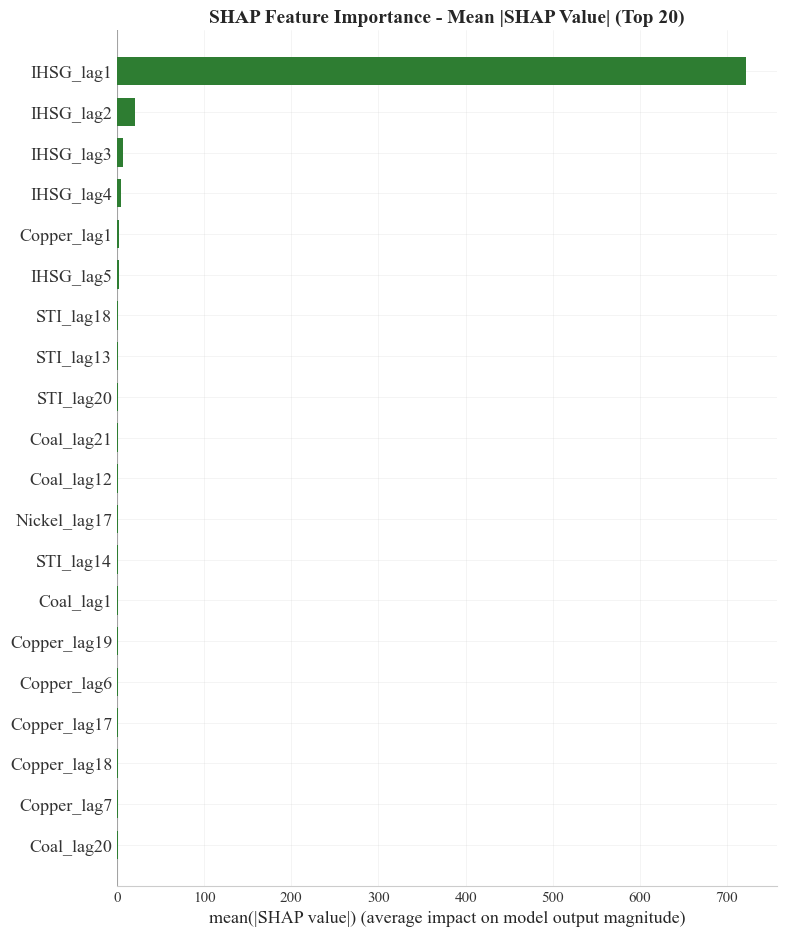

Figure saved: model2-figure/model2_shap_importance_bar.png (300 DPI)


In [66]:
# SHAP Summary Plot (Bar) with thesis color
fig, ax = plt.subplots(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample_df, plot_type="bar", show=False, max_display=20, color=COLORS['IHSG'])
plt.title('SHAP Feature Importance - Mean |SHAP Value| (Top 20)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model2-figure/model2_shap_importance_bar.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2-figure/model2_shap_importance_bar.png (300 DPI)")

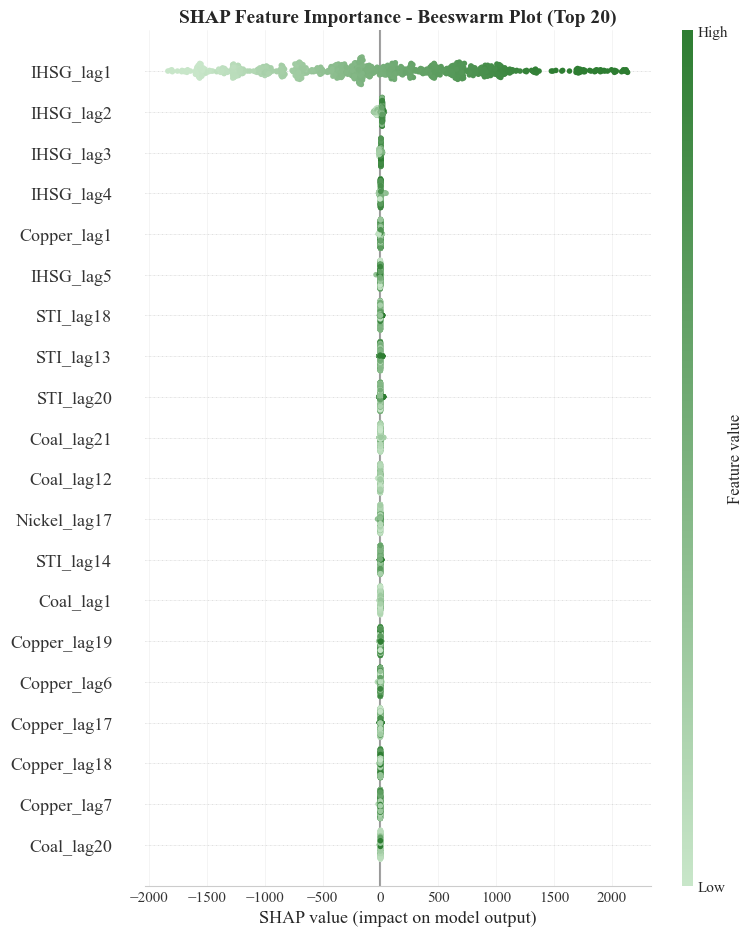

Figure saved: model2-figure/model2_shap_importance_beeswarm.png (300 DPI)


In [67]:
# SHAP Summary Plot (Beeswarm) with custom colormap
fig, ax = plt.subplots(figsize=(12, 12))

# Custom colormap for SHAP beeswarm (Green gradient)
from matplotlib.colors import LinearSegmentedColormap
shap_cmap = LinearSegmentedColormap.from_list('shap_green', ['#C8E6C9', '#2E7D32'], N=256)

shap.summary_plot(shap_values, X_sample_df, show=False, max_display=20, cmap=shap_cmap)
plt.title('SHAP Feature Importance - Beeswarm Plot (Top 20)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model2-figure/model2_shap_importance_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2-figure/model2_shap_importance_beeswarm.png (300 DPI)")

In [68]:
# Calculate aggregated feature importance by variable (not by lag)
feature_importance_by_var = {}

for col in X_sample_df.columns:
    # Extract variable name (remove lag suffix)
    if '_lag' in col:
        var_name = col.rsplit('_lag', 1)[0]
    else:
        var_name = col
    
    col_idx = list(X_sample_df.columns).index(col)
    importance = np.abs(shap_values[:, col_idx]).mean()
    
    if var_name not in feature_importance_by_var:
        feature_importance_by_var[var_name] = 0
    feature_importance_by_var[var_name] += importance

# Sort by importance
sorted_importance = dict(sorted(feature_importance_by_var.items(), key=lambda x: x[1], reverse=True))

print("="*60)
print("AGGREGATED FEATURE IMPORTANCE BY VARIABLE")
print("="*60)
total_importance = sum(sorted_importance.values())
for var, importance in sorted_importance.items():
    pct = (importance / total_importance) * 100
    bar = "█" * int(pct / 2)
    print(f"{var:15} : {importance:8.4f} ({pct:5.2f}%) {bar}")

AGGREGATED FEATURE IMPORTANCE BY VARIABLE
IHSG            : 754.2485 (91.80%) █████████████████████████████████████████████
STI             :  13.5196 ( 1.65%) 
Copper          :  11.6838 ( 1.42%) 
Coal            :  10.6616 ( 1.30%) 
Nickel          :   8.7508 ( 1.07%) 
Tin             :   8.1069 ( 0.99%) 
Gold            :   7.9323 ( 0.97%) 
Silver          :   6.7448 ( 0.82%) 


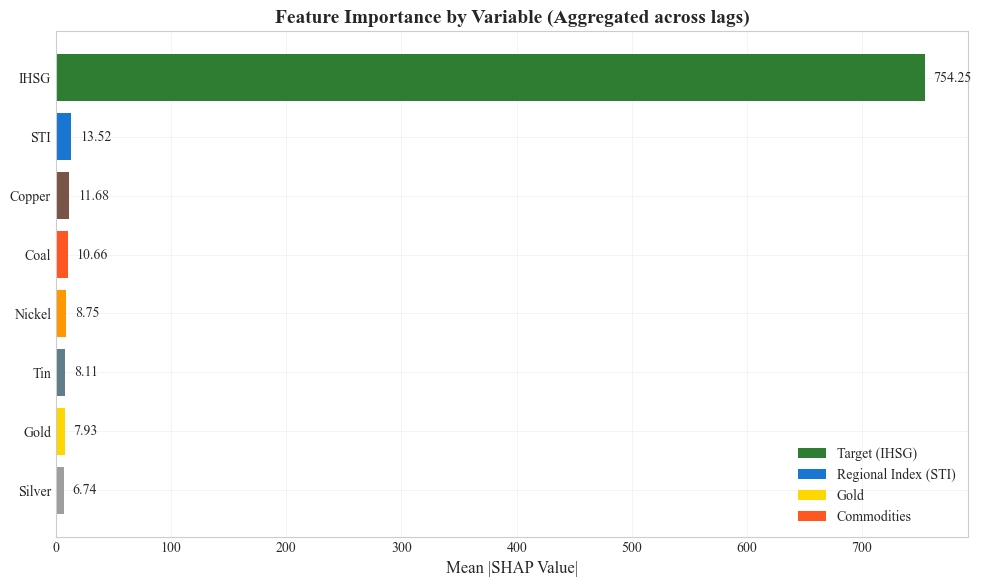

Figure saved: model2-figure/model2_feature_importance_aggregated.png (300 DPI)


In [69]:
# =========================================================================
# VISUALIZATION: AGGREGATED FEATURE IMPORTANCE
# =========================================================================
fig, ax = plt.subplots(figsize=(10, 6))

vars_names = list(sorted_importance.keys())
importances = list(sorted_importance.values())

# Color coding with thesis palette
bar_colors = []
for v in vars_names:
    if 'IHSG' in v:
        bar_colors.append(COLORS['IHSG'])
    elif 'STI' in v:
        bar_colors.append(COLORS['STI'])
    elif 'Gold' in v:
        bar_colors.append(COLORS['Gold'])
    elif 'Coal' in v:
        bar_colors.append(COLORS['Coal'])
    elif 'Copper' in v:
        bar_colors.append(COLORS['Copper'])
    elif 'Silver' in v:
        bar_colors.append(COLORS['Silver'])
    elif 'Tin' in v:
        bar_colors.append(COLORS['Tin'])
    elif 'Nickel' in v:
        bar_colors.append(COLORS['Nickel'])
    else:
        bar_colors.append(COLORS['error'])

bars = ax.barh(vars_names[::-1], importances[::-1], color=bar_colors[::-1])
ax.set_xlabel('Mean |SHAP Value|', fontsize=12)
ax.set_title('Feature Importance by Variable (Aggregated across lags)', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, importances[::-1]):
    ax.text(val + max(importances)*0.01, bar.get_y() + bar.get_height()/2, 
            f'{val:.2f}', va='center', fontsize=10)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=COLORS['IHSG'], label='Target (IHSG)'),
    Patch(facecolor=COLORS['STI'], label='Regional Index (STI)'),
    Patch(facecolor=COLORS['Gold'], label='Gold'),
    Patch(facecolor=COLORS['Coal'], label='Commodities')
]
ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)

plt.tight_layout()
plt.savefig('model2-figure/model2_feature_importance_aggregated.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2-figure/model2_feature_importance_aggregated.png (300 DPI)")

## 11. Results Summary

In [70]:
# =========================================================================
# FINAL SUMMARY
# =========================================================================
print("="*70)
print("HASIL PENELITIAN MODEL 2: IHSG DENGAN KOMODITAS DAN STI (DAILY)")
print("="*70)

print("\nDATA:")
print(f"   - Periode Data     : {df['Date'].min().strftime('%d %B %Y')} - {df['Date'].max().strftime('%d %B %Y')}")
print(f"   - Total Observasi  : {len(df)} hari trading")
print(f"   - Train/Test Split : {TRAIN_RATIO*100:.0f}% / {(1-TRAIN_RATIO)*100:.0f}%")

print("\nTARGET:")
print(f"   - Variabel Target  : IHSG (Indeks Harga Saham Gabungan) - Daily")

print("\nCOVARIATES:")
print("   Regional Index:")
print("     1. STI (Straits Times Index)")
print("   Commodities:")
for i, col in enumerate(['Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel'], 2):
    print(f"     {i}. {col}")

print("\nBEST HYPERPARAMETERS:")
for param, value in best_params.items():
    print(f"   - {param}: {value}")

print("\nMODEL PERFORMANCE (Random Forest):")
print(f"   - MAPE  : {mape_score:.4f}%")
print(f"   - RMSE  : {rmse_score:.4f}")
print(f"   - MAE   : {mae_score:.4f}")
print(f"   - R2    : {r2:.4f}")

print("\nFEATURE IMPORTANCE (SHAP - Top 3):")
for i, (var, imp) in enumerate(list(sorted_importance.items())[:3], 1):
    pct = (imp / total_importance) * 100
    print(f"   {i}. {var}: {pct:.2f}%")

print("\n" + "="*70)
print("Source: Author's calculation, 2025")
print("="*70)

HASIL PENELITIAN MODEL 2: IHSG DENGAN KOMODITAS DAN STI (DAILY)

DATA:
   - Periode Data     : 02 January 2015 - 30 December 2025
   - Total Observasi  : 2564 hari trading
   - Train/Test Split : 80% / 20%

TARGET:
   - Variabel Target  : IHSG (Indeks Harga Saham Gabungan) - Daily

COVARIATES:
   Regional Index:
     1. STI (Straits Times Index)
   Commodities:
     2. Gold
     3. Coal
     4. Copper
     5. Silver
     6. Tin
     7. Nickel

BEST HYPERPARAMETERS:
   - lags: 5
   - lags_past_covariates: 21
   - n_estimators: 300
   - max_depth: None
   - max_features: None
   - min_samples_split: 5
   - min_samples_leaf: 4
   - bootstrap: False
   - output_chunk_length: 1

MODEL PERFORMANCE (Random Forest):
   - MAPE  : 3.5381%
   - RMSE  : 462.7110
   - MAE   : 279.8590
   - R2    : 0.2512

FEATURE IMPORTANCE (SHAP - Top 3):
   1. IHSG: 91.80%
   2. STI: 1.65%
   3. Copper: 1.42%

Source: Author's calculation, 2025


In [ ]:
# =========================================================================
# SAVE RESULTS
# =========================================================================
# Align test_actual with predictions (predictions may be shorter due to lags)
test_actual_save = test_actual.slice_intersect(predictions)
pred_save = predictions.slice_intersect(test_actual)

# Load date mapping (format: dd/mm/yyyy)
date_map = pd.read_csv('trading_day_mapping.csv')
date_map['Date'] = pd.to_datetime(date_map['Date'], format='%d/%m/%Y')

# Get actual dates from indices
result_dates = date_map.loc[test_actual_save.time_index.values, 'Date'].values

results_df = pd.DataFrame({
    'Date': result_dates,
    'Actual_IHSG': test_actual_save.values().flatten(),
    'Predicted_IHSG': pred_save.values().flatten(),
    'Error': (pred_save.values().flatten() - test_actual_save.values().flatten()),
    'APE_%': np.abs((pred_save.values().flatten() - test_actual_save.values().flatten()) / test_actual_save.values().flatten()) * 100
})

results_df.to_csv('model2_predictions.csv', index=False)
print("Predictions saved to 'model2_predictions.csv'")

# Also save the merged dataset
df.to_csv('model2_merged_data.csv', index=False)
print("Merged dataset saved to 'model2_merged_data.csv'")

# Display prediction results
print("\nPrediction Results (first 10 rows):")
results_df.head(10).round(2)

Predictions saved to 'model2_predictions.csv'
Merged dataset saved to 'model2_merged_data.csv'

Prediction Results (first 10 rows):


,Date,Actual_IHSG,Predicted_IHSG,Error,APE_%
0,2023-10-13,6926.78,6958.01,31.23,0.45
1,2023-10-16,6896.29,6894.26,-2.03,0.03
2,2023-10-17,6939.61,6894.26,-45.35,0.65
3,2023-10-18,6927.91,6958.01,30.10,0.43
4,2023-10-19,6846.43,6894.26,47.83,0.70
5,2023-10-20,6849.17,6894.26,45.09,0.66
6,2023-10-23,6741.96,6894.26,152.30,2.26
7,2023-10-24,6806.76,6803.84,-2.93,0.04
8,2023-10-25,6834.39,6803.84,-30.55,0.45
9,2023-10-26,6714.52,6894.26,179.74,2.68


## 12. Benchmark: XGBoost Model

In [72]:
# =========================================================================
# XGBOOST HYPERPARAMETER TUNING
# =========================================================================
from darts.models import XGBModel

print("="*60)
print("XGBOOST HYPERPARAMETER TUNING WITH OPTUNA")
print("="*60)
print(f"\nForecast Horizon: {OUTPUT_CHUNK_LENGTH} day(s) ahead")
print("\nSearch Space:")
print("  [Darts Parameters]")
print("  lags: [5, 10, 21, 42] (categorical)")
print("  lags_past_covariates: [5, 10, 21, 42] (categorical)")
print("\n  [XGBoost Parameters]")
print("  n_estimators: [100, 200, 300] (categorical)")
print("  max_depth: [3, 5, 7, 10] (categorical)")
print("  learning_rate: [0.01, 0.05, 0.1, 0.2] (categorical)")
print("  subsample: [0.6, 0.8, 1.0] (categorical)")
print("  colsample_bytree: [0.6, 0.8, 1.0] (categorical)")

XGBOOST HYPERPARAMETER TUNING WITH OPTUNA

Forecast Horizon: 1 day(s) ahead

Search Space:
  [Darts Parameters]
  lags: [5, 10, 21, 42] (categorical)
  lags_past_covariates: [5, 10, 21, 42] (categorical)

  [XGBoost Parameters]
  n_estimators: [100, 200, 300] (categorical)
  max_depth: [3, 5, 7, 10] (categorical)
  learning_rate: [0.01, 0.05, 0.1, 0.2] (categorical)
  subsample: [0.6, 0.8, 1.0] (categorical)
  colsample_bytree: [0.6, 0.8, 1.0] (categorical)


In [73]:
# =========================================================================
# XGBOOST OPTUNA OPTIMIZATION
# =========================================================================
import optuna
from optuna.samplers import TPESampler

optuna.logging.set_verbosity(optuna.logging.WARNING)

def xgb_objective(trial):
    """Objective function for XGBoost Optuna optimization"""
    
    # Darts parameters
    lags = trial.suggest_categorical('lags', [5, 10, 21, 42])
    lags_past_covariates = trial.suggest_categorical('lags_past_covariates', [5, 10, 21, 42])
    
    # XGBoost specific parameters
    n_estimators = trial.suggest_categorical('n_estimators', [100, 200, 300])
    max_depth = trial.suggest_categorical('max_depth', [3, 5, 7, 10])
    learning_rate = trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.2])
    subsample = trial.suggest_categorical('subsample', [0.6, 0.8, 1.0])
    colsample_bytree = trial.suggest_categorical('colsample_bytree', [0.6, 0.8, 1.0])
    
    try:
        model = XGBModel(
            lags=lags,
            lags_past_covariates=lags_past_covariates,
            output_chunk_length=OUTPUT_CHUNK_LENGTH,
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42,
            verbosity=0
        )
        
        model.fit(
            train_target_scaled, 
            past_covariates=cov_scaled
        )
        
        backtest_pred = model.historical_forecasts(
            series=target_scaled,
            past_covariates=cov_scaled,
            start=test_target_scaled.start_time(),
            forecast_horizon=1,
            retrain=False,
            verbose=False
        )
        
        mape_score = mape(test_target_scaled, backtest_pred)
        return mape_score
        
    except Exception as e:
        return float('inf')

def xgb_print_callback(study, trial):
    if trial.number % 10 == 0:
        print(f"  Trial {trial.number}: MAPE = {trial.value:.4f}% | Best so far: {study.best_value:.4f}%")

print("="*60)
print("RUNNING XGBOOST OPTUNA OPTIMIZATION")
print("="*60)

XGB_N_TRIALS = 100
total_xgb_combinations = 4 * 4 * 3 * 4 * 4 * 3 * 3
print(f"\nTotal possible combinations: {total_xgb_combinations}")
print(f"Number of trials: {XGB_N_TRIALS} ({XGB_N_TRIALS/total_xgb_combinations*100:.1f}% of search space)")
print(f"Forecast horizon: {OUTPUT_CHUNK_LENGTH} day (1-step-ahead)")
print(f"\nCovariates:")
print(f"  - Past: {covariates.components.tolist()}")
print("\nProgress (every 10 trials):")

xgb_study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42)
)

xgb_study.optimize(
    xgb_objective, 
    n_trials=XGB_N_TRIALS, 
    callbacks=[xgb_print_callback],
    show_progress_bar=True
)

xgb_best_params = xgb_study.best_trial.params.copy()
xgb_best_params['output_chunk_length'] = OUTPUT_CHUNK_LENGTH
xgb_best_score = xgb_study.best_value

print("\n" + "="*60)
print("XGBOOST OPTUNA RESULTS")
print("="*60)
print(f"Best MAPE Score: {xgb_best_score:.4f}%")
print(f"Total Trials: {len(xgb_study.trials)}")
print(f"\nBest Hyperparameters:")
for param, value in xgb_best_params.items():
    print(f"  {param}: {value}")

print("\n" + "="*60)
print("TOP 5 TRIALS")
print("="*60)
xgb_trials_df = xgb_study.trials_dataframe()
xgb_trials_df = xgb_trials_df.sort_values('value').head(5)
for idx, row in xgb_trials_df.iterrows():
    print(f"  Trial {row['number']}: MAPE = {row['value']:.4f}%")

RUNNING XGBOOST OPTUNA OPTIMIZATION

Total possible combinations: 6912
Number of trials: 100 (1.4% of search space)
Forecast horizon: 1 day (1-step-ahead)

Covariates:
  - Past: ['STI', 'Gold', 'Coal', 'Copper', 'Silver', 'Tin', 'Nickel']

Progress (every 10 trials):


  0%|          | 0/100 [00:00<?, ?it/s]

  Trial 0: MAPE = 11.5532% | Best so far: 11.5532%
  Trial 10: MAPE = 13.7147% | Best so far: 9.3378%
  Trial 20: MAPE = 12.0122% | Best so far: 9.3378%
  Trial 30: MAPE = 9.6183% | Best so far: 8.2668%
[W 2026-02-05 19:06:11,087] Trial 38 failed with parameters: {'lags': 5, 'lags_past_covariates': 42, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.6} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\tsuser\AppData\Local\Programs\Python\Python314\Lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\tsuser\AppData\Local\Temp\ipykernel_18024\2287345123.py", line 37, in xgb_objective
    model.fit(
    ~~~~~~~~~^
        train_target_scaled,
        ^^^^^^^^^^^^^^^^^^^^
        past_covariates=cov_scaled
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\tsuser\AppData\Local\Programs\Python\Python314\Li

KeyboardInterrupt: 

In [ ]:
# =========================================================================
# TRAIN FINAL XGBOOST MODEL
# =========================================================================
print("\n" + "="*60)
print("TRAINING FINAL XGBOOST MODEL")
print("="*60)

xgb_final_model = XGBModel(
    lags=xgb_best_params['lags'],
    lags_past_covariates=xgb_best_params['lags_past_covariates'],
    output_chunk_length=OUTPUT_CHUNK_LENGTH,
    n_estimators=xgb_best_params['n_estimators'],
    max_depth=xgb_best_params['max_depth'],
    learning_rate=xgb_best_params['learning_rate'],
    subsample=xgb_best_params['subsample'],
    colsample_bytree=xgb_best_params['colsample_bytree'],
    random_state=42,
    verbosity=0
)

xgb_final_model.fit(
    train_target_scaled, 
    past_covariates=cov_scaled
)
print("XGBoost model trained successfully!")

In [ ]:
# =========================================================================
# XGBOOST PREDICTIONS & EVALUATION
# =========================================================================
xgb_predictions_scaled = xgb_final_model.historical_forecasts(
    series=target_scaled,
    past_covariates=cov_scaled,
    start=test_target_scaled.start_time(),
    forecast_horizon=1,
    retrain=False,
    verbose=True
)

xgb_predictions = scaler_target.inverse_transform(xgb_predictions_scaled)

# Calculate metrics
xgb_mape = mape(test_actual, xgb_predictions)
xgb_rmse = rmse(test_actual, xgb_predictions)
xgb_mae = mae(test_actual, xgb_predictions)
xgb_r2 = r2_score(test_actual, xgb_predictions)

print("="*60)
print("XGBOOST MODEL EVALUATION")
print("="*60)
print(f"MAPE: {xgb_mape:.4f}%")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE:  {xgb_mae:.4f}")
print(f"R2:   {xgb_r2:.4f}")

In [ ]:
# =========================================================================
# MODEL COMPARISON: RANDOM FOREST vs XGBOOST
# =========================================================================
print("="*70)
print("MODEL COMPARISON: RANDOM FOREST vs XGBOOST")
print("="*70)

comparison_df = pd.DataFrame({
    'Metric': ['MAPE (%)', 'RMSE', 'MAE', 'R2'],
    'Random Forest': [mape_score, rmse_score, mae_score, r2],
    'XGBoost': [xgb_mape, xgb_rmse, xgb_mae, xgb_r2]
})

comparison_df['Winner'] = comparison_df.apply(
    lambda row: 'Random Forest' if (
        (row['Metric'] in ['MAPE (%)', 'RMSE', 'MAE'] and row['Random Forest'] < row['XGBoost']) or
        (row['Metric'] == 'R2' and row['Random Forest'] > row['XGBoost'])
    ) else 'XGBoost', axis=1
)

print(comparison_df.to_string(index=False))

rf_wins = (comparison_df['Winner'] == 'Random Forest').sum()
xgb_wins = (comparison_df['Winner'] == 'XGBoost').sum()

print("\n" + "="*70)
if rf_wins > xgb_wins:
    print(f"WINNER: Random Forest ({rf_wins}/4 metrics)")
elif xgb_wins > rf_wins:
    print(f"WINNER: XGBoost ({xgb_wins}/4 metrics)")
else:
    print(f"TIE: Both models perform similarly")
print("="*70)

MODEL COMPARISON: RANDOM FOREST vs XGBOOST
  Metric  Random Forest    XGBoost        Winner
MAPE (%)       4.502391   4.631952 Random Forest
    RMSE     528.338256 521.263300       XGBoost
     MAE     348.593093 356.220468 Random Forest
      R2      -0.024048   0.003195       XGBoost

TIE: Both models perform similarly


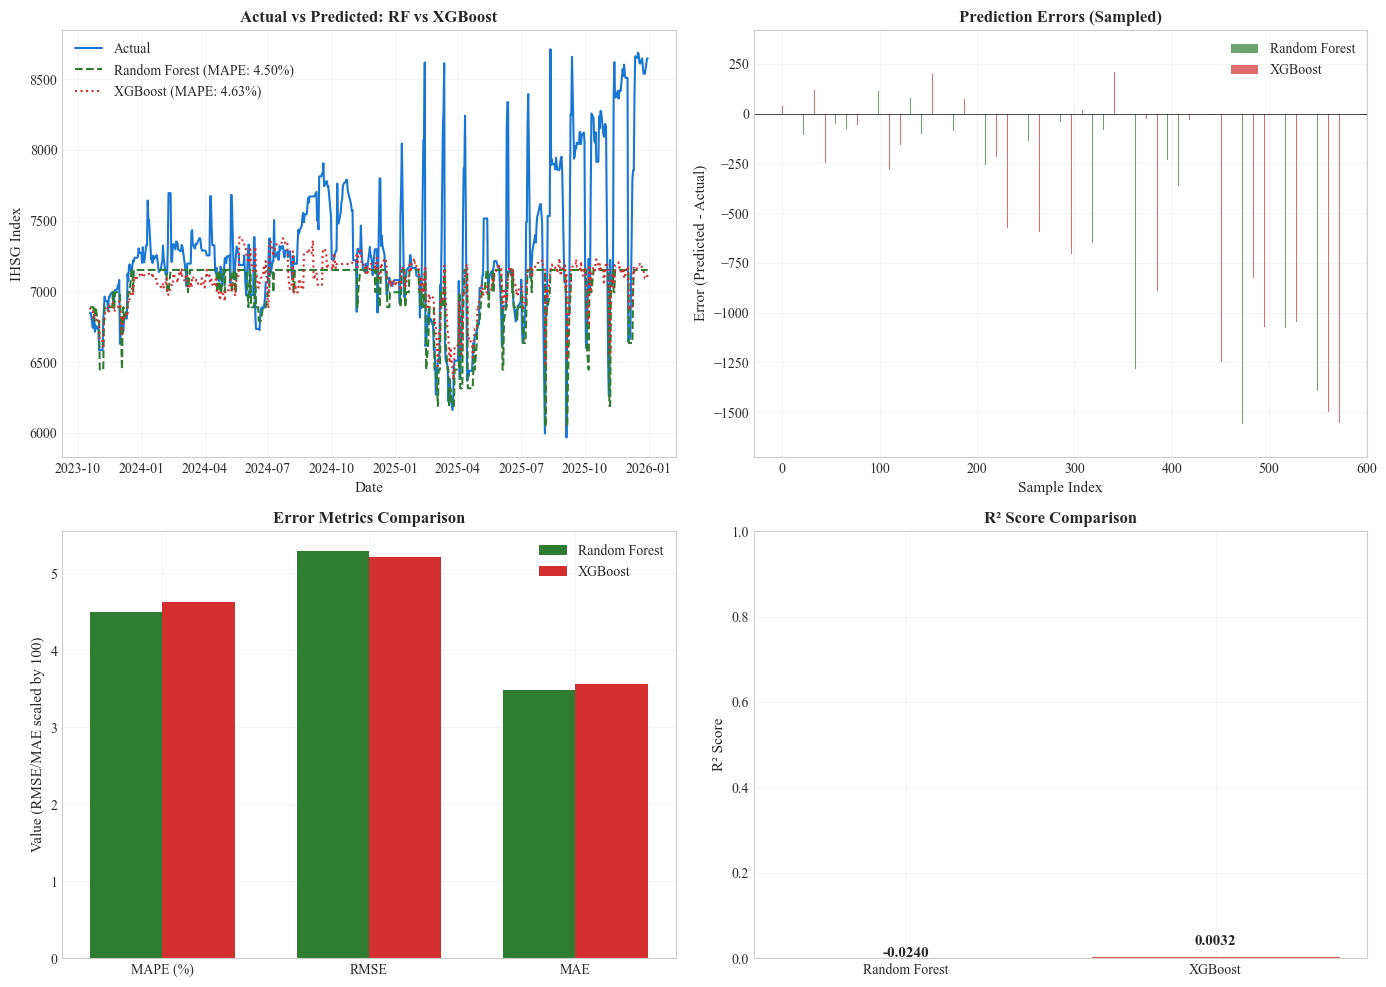

Figure saved: model2_comparison_rf_xgb.png (300 DPI)


In [ ]:
# =========================================================================
# VISUALIZATION: RANDOM FOREST vs XGBOOST
# =========================================================================
# Load date mapping (format: dd/mm/yyyy)
date_map = pd.read_csv('trading_day_mapping.csv')
date_map['Date'] = pd.to_datetime(date_map['Date'], format='%d/%m/%Y')
test_dates = date_map.loc[test_actual.time_index.values, 'Date'].values
pred_dates = date_map.loc[predictions.time_index.values, 'Date'].values
xgb_pred_dates = date_map.loc[xgb_predictions.time_index.values, 'Date'].values

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Actual vs Predictions (Both Models)
ax1 = axes[0, 0]
ax1.plot(test_dates, test_actual.values(), 
         label='Actual', color=COLORS['actual'], linewidth=1.5)
ax1.plot(pred_dates, predictions.values(), 
         label=f'Random Forest (MAPE: {mape_score:.2f}%)', 
         color=COLORS['IHSG'], linewidth=1.5, linestyle='--')
ax1.plot(xgb_pred_dates, xgb_predictions.values(), 
         label=f'XGBoost (MAPE: {xgb_mape:.2f}%)', 
         color=COLORS['predicted'], linewidth=1.5, linestyle=':')
ax1.set_title('Actual vs Predicted: RF vs XGBoost', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('IHSG Index')
ax1.legend(loc='upper left', framealpha=0.9)
ax1.grid(True, alpha=0.3)

# Plot 2: Prediction Errors
ax2 = axes[0, 1]
rf_errors = (predictions.values().flatten() - test_actual.slice_intersect(predictions).values().flatten())
xgb_errors = (xgb_predictions.values().flatten() - test_actual.slice_intersect(xgb_predictions).values().flatten())

# Sample for clearer visualization (daily data has many points)
sample_idx = np.arange(0, len(rf_errors), max(1, len(rf_errors)//50))
ax2.bar(sample_idx - 0.2, rf_errors[sample_idx], 0.4, 
        label='Random Forest', color=COLORS['IHSG'], alpha=0.7)
ax2.bar(sample_idx + 0.2, xgb_errors[sample_idx], 0.4, 
        label='XGBoost', color=COLORS['predicted'], alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_title('Prediction Errors (Sampled)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Error (Predicted - Actual)')
ax2.legend(loc='upper right', framealpha=0.9)
ax2.grid(True, alpha=0.3)

# Plot 3: Metrics Comparison Bar Chart
ax3 = axes[1, 0]
metrics = ['MAPE (%)', 'RMSE', 'MAE']
rf_values = [mape_score, rmse_score/100, mae_score/100]
xgb_values = [xgb_mape, xgb_rmse/100, xgb_mae/100]
x = np.arange(len(metrics))
width = 0.35
bars1 = ax3.bar(x - width/2, rf_values, width, label='Random Forest', color=COLORS['IHSG'])
bars2 = ax3.bar(x + width/2, xgb_values, width, label='XGBoost', color=COLORS['predicted'])
ax3.set_ylabel('Value (RMSE/MAE scaled by 100)')
ax3.set_title('Error Metrics Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics)
ax3.legend(loc='upper right', framealpha=0.9)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: R² Comparison
ax4 = axes[1, 1]
models = ['Random Forest', 'XGBoost']
r2_values = [r2, xgb_r2]
colors_bar = [COLORS['IHSG'], COLORS['predicted']]
bars = ax4.bar(models, r2_values, color=colors_bar, alpha=0.8)
ax4.set_ylabel('R² Score')
ax4.set_title('R² Score Comparison', fontsize=12, fontweight='bold')
ax4.set_ylim(0, 1)
for bar, val in zip(bars, r2_values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model2-figure/model2_comparison_rf_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: model2-figure/model2_comparison_rf_xgb.png (300 DPI)")

In [ ]:
# =========================================================================
# DIAGNOSIS: WHY PREDICTIONS MAY APPEAR SIMILAR?
# =========================================================================
print("="*70)
print("MODEL WINDOW AND HORIZON EXPLANATION")
print("="*70)

print("\n1. FORECAST HORIZON (output_chunk_length):")
print(f"   - Value: {OUTPUT_CHUNK_LENGTH} day")
print("   - Meaning: Model predicts 1 day ahead at a time")
print("   - Each prediction is for t+1 given data up to t")

print(f"\n2. LOOKBACK WINDOW (lags):")
print(f"   - Target lags: {best_params['lags']} days")
print(f"   - Covariate lags: {best_params['lags_past_covariates']} days")
print(f"   - Meaning: Model uses {best_params['lags']} days of IHSG history")
print(f"             and {best_params['lags_past_covariates']} days of covariate history")

print("\n3. HOW historical_forecasts WORKS:")
print("   Day 1: Use [t-10, t-9, ..., t-1, t] → Predict t+1")
print("   Day 2: Use [t-9, t-8, ..., t, t+1_actual] → Predict t+2")
print("   Day 3: Use [t-8, t-7, ..., t+1, t+2_actual] → Predict t+3")
print("   ...")
print("   (Sliding window, always predicting 1-step ahead)")

print("\n4. POTENTIAL CAUSES OF SIMILAR PREDICTIONS:")

# Check prediction variance
pred_values = predictions.values().flatten()
pred_diff = np.diff(pred_values)
zero_diff_pct = (np.abs(pred_diff) < 0.01).sum() / len(pred_diff) * 100

print(f"\n   a) Prediction Variance Analysis:")
print(f"      - Std of predictions: {pred_values.std():.2f}")
print(f"      - Std of actuals: {test_actual.values().flatten().std():.2f}")
print(f"      - % of consecutive predictions with <0.01 diff: {zero_diff_pct:.1f}%")

# Check if ffill caused many duplicates
df_check = df_ts.copy()
duplicate_pct = (df_check.diff() == 0).mean() * 100
print(f"\n   b) Data after ffill (% unchanged from previous day):")
for col in ['IHSG'] + COVARIATE_COLS:
    dup_pct = (df_check[col].diff() == 0).sum() / len(df_check) * 100
    print(f"      {col}: {dup_pct:.1f}%")

print("\n5. INTERPRETATION:")
print("   - Random Forest tends to predict 'smoothed' values")
print("   - With short lags (10 days), recent trends dominate")
print("   - Tree-based models may predict similar values when")
print("     input features are similar (especially after ffill)")
print("   - This is normal behavior for RF on financial time series")

print("\n" + "="*70)

MODEL WINDOW AND HORIZON EXPLANATION

1. FORECAST HORIZON (output_chunk_length):
   - Value: 1 day
   - Meaning: Model predicts 1 day ahead at a time
   - Each prediction is for t+1 given data up to t

2. LOOKBACK WINDOW (lags):
   - Target lags: 10 days
   - Covariate lags: 5 days
   - Meaning: Model uses 10 days of IHSG history
             and 5 days of covariate history

3. HOW historical_forecasts WORKS:
   Day 1: Use [t-10, t-9, ..., t-1, t] → Predict t+1
   Day 2: Use [t-9, t-8, ..., t, t+1_actual] → Predict t+2
   Day 3: Use [t-8, t-7, ..., t+1, t+2_actual] → Predict t+3
   ...
   (Sliding window, always predicting 1-step ahead)

4. POTENTIAL CAUSES OF SIMILAR PREDICTIONS:

   a) Prediction Variance Analysis:
      - Std of predictions: 228.20
      - Std of actuals: 522.10
      - % of consecutive predictions with <0.01 diff: 74.0%

   b) Data after ffill (% unchanged from previous day):
      IHSG: 20.9%
      STI: 20.9%
      Coal: 26.7%
      Copper: 21.3%
      Silver: 20.